# Handling and analysis of the Enron Email Dataset - Part 2

In [1]:
%matplotlib inline
from IPython.display import display, HTML
import numpy as np
import pandas as pd
from enrondatahandling import EnronEmailDataset
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# Load and parse the enron email dataset
enronData = EnronEmailDataset('./data')

Surveyed 1702 email files
Parsed 1702 emails
Found 83 responses


-------------------
# Further clarification of the analysis done in Part 1
## Who are the biggest email senders?
#### _Note: Separated out between direct, broadcast and all emails_
#### _Note: Not sure why there are emails that have NO recipients at all_

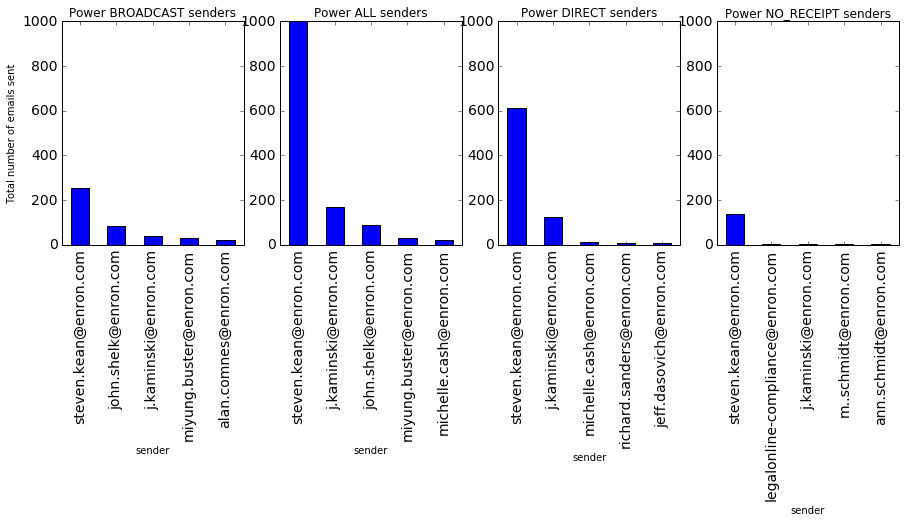

In [3]:
def count_senders(df):
    return (
        df.groupby('sender')
        .count().rename(columns={'ts': 'count'})
        .sort_values(by='count', ascending=[0]))
        
power_senders = {
    "ALL": count_senders(enronData.emails[['sender', 'ts']]),
    "DIRECT": count_senders(enronData.emails[enronData.emails.num_recipients == 1][['sender', 'ts']]),
    "BROADCAST": count_senders(enronData.emails[enronData.emails.num_recipients > 1][['sender', 'ts']]),
    "NO_RECEIPT": count_senders(enronData.emails[enronData.emails.num_recipients == 0][['sender', 'ts']])
}

_, axs = plt.subplots(1, len(power_senders))

all_plots = []
max_ybound = 0
for name, df in power_senders.iteritems():
    plot = df[:5].plot(
        ax=axs[len(all_plots)], 
        kind='bar', 
        legend=None, 
        title="Power {} senders".format(name), 
        figsize=(15, 4), 
        fontsize=14)
    all_plots.append(plot)
    max_ybound = max(max_ybound, plot.get_ybound())

all_plots[0].set_ylabel("Total number of emails sent")

# Make the y axes the same in all plots
for plot in all_plots:
    plot.set_ybound(max_ybound)

## Who are the biggest email receivers?

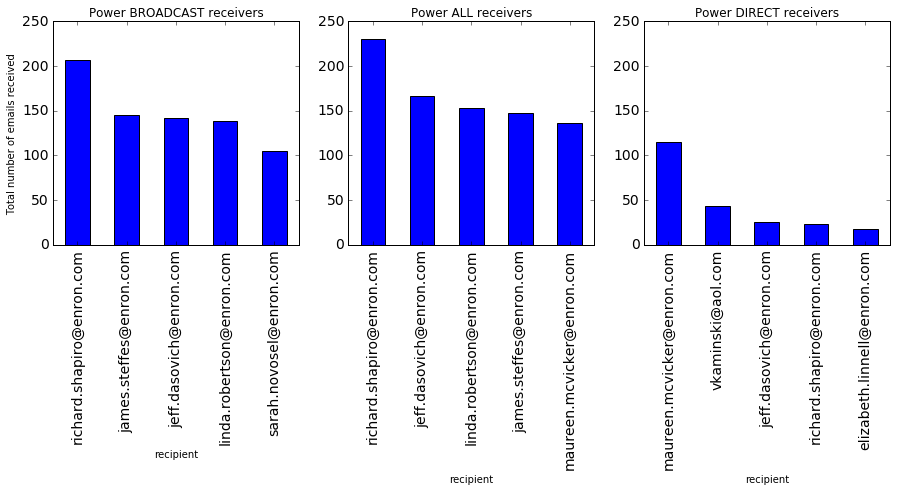

In [4]:
def count_recipients(df):
    return (
        df
        .groupby('recipient')
        .count()[['email_id']]
        .rename(columns={'email_id': 'count'})
        .sort_values(by='count', ascending=[0])
)

recipients = pd.merge(
    enronData.recipients[['recipient', 'email_id']], 
    enronData.emails[['num_recipients']], 
    left_on='email_id', 
    right_index=True)

power_receivers = {
    "ALL": count_recipients(recipients),
    "DIRECT": count_recipients(recipients[recipients['num_recipients'] == 1]),
    "BROADCAST": count_recipients(recipients[recipients['num_recipients'] > 1])
}

_, axs = plt.subplots(1, len(power_receivers))

all_plots = []
max_ybound = 0
for name, df in power_receivers.iteritems():
    plot = df[:5].plot(
        ax=axs[len(all_plots)], 
        kind='bar', 
        legend=None, 
        title="Power {} receivers".format(name), 
        figsize=(15, 4), 
        fontsize=14)
    all_plots.append(plot)
    max_ybound = max(max_ybound, plot.get_ybound())

all_plots[0].set_ylabel("Total number of emails received")

# Make the y axes the same in all plots
for plot in all_plots:
    plot.set_ybound(max_ybound)


## Who was cc'ed the most in general and in otherwise "direct" emails?
#### _Note: Seems Bcc is not really a thing for them_

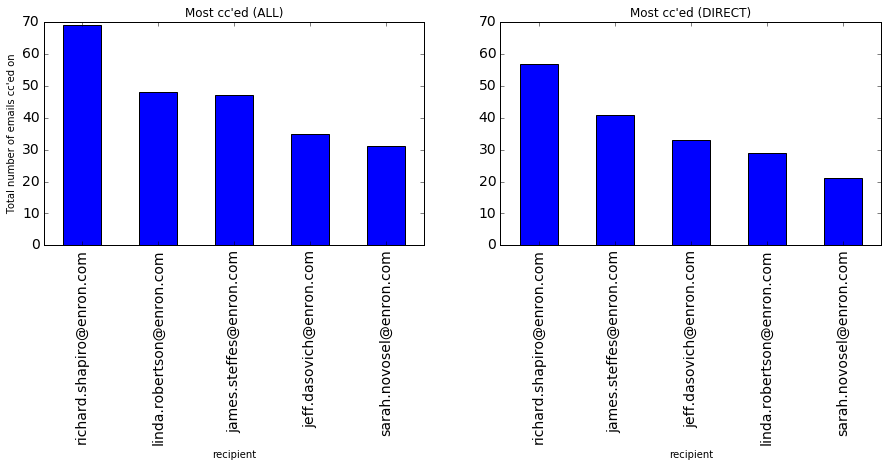

In [5]:
recipients = pd.merge(
    enronData.recipients, 
    enronData.emails[['num_tos']], 
    left_on='email_id', 
    right_index=True)

def count_most_cced(df):
    return (
        df
        .groupby('recipient')
        .count()[['email_id']]
        .rename(columns={'email_id': 'count'})
        .sort_values(by='count', ascending=[0]))

power_cced = {
    "ALL": count_most_cced(recipients[(recipients['type'] == 'cc')]),
    "DIRECT": count_most_cced(recipients[(recipients['type'] == 'cc') & (recipients['num_tos'] == 1)])
}

_, axs = plt.subplots(1, len(power_cced))

all_plots = []
max_ybound = 0
for name, df in power_cced.iteritems():
    plot = df[:5].plot(
        ax=axs[len(all_plots)], 
        kind='bar', 
        legend=None, 
        title="Most cc'ed ({})".format(name),
        figsize=(15, 4), 
        fontsize=14)
    all_plots.append(plot)
    max_ybound = max(max_ybound, plot.get_ybound())

all_plots[0].set_ylabel("Total number of emails cc'ed on")

# Make the y axes the same in all plots
for plot in all_plots:
    plot.set_ybound(max_ybound)

## Fastest response times, split by direct vs broadcast emails

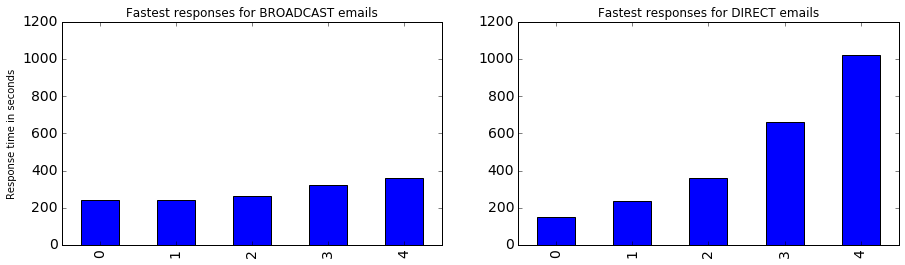

In [6]:
response_times = {
    "DIRECT":enronData.responses[enronData.responses['num_recipients'] == 1]
    .sort_values(by='response_time_in_secs')
    .reset_index()[['sender_response', 'subject', 'response_time_in_secs']],
    "BROADCAST":enronData.responses[enronData.responses['num_recipients'] > 1]
    .sort_values(by='response_time_in_secs')
    .reset_index()[['sender_response', 'subject', 'response_time_in_secs']]
}

_, axs = plt.subplots(1, len(response_times))

all_plots = []
max_ybound = 0
for name, df in response_times.iteritems():
    plot = df[:5].plot(
        ax=axs[len(all_plots)], 
        kind='bar', 
        legend=None, 
        title="Fastest responses for {} emails".format(name),
        figsize=(15, 4), 
        fontsize=14)
    all_plots.append(plot)
    max_ybound = max(max_ybound, plot.get_ybound())

all_plots[0].set_ylabel("Response time in seconds")

# Make the y axes the same in all plots
for plot in all_plots:
    plot.set_ybound(max_ybound)

----------------------------
# Long response chains

## Approximately, how long are the email response chains? Let's plot the counts of email chains of various lengths

#### _Note: The code below will underestimate this a little because if the same email has two responses, those are considered separate response chains for the purpose of the computation below_
#### _Note: Y-axis is on log scale_

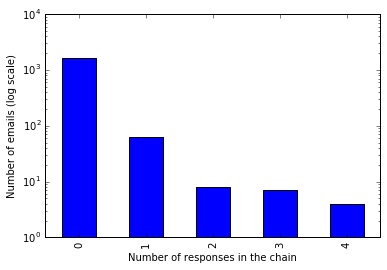

In [7]:
def build_response_chains():
    responses = enronData.responses[['email_id', 'email_id_response']]
    max_response_level=0
    response_chains = enronData.emails[['email_id']].rename(columns={'email_id':'email_id_response' + str(max_response_level)})
    while(True):
        max_response_level += 1
        new_col_name = 'email_id_response' + str(max_response_level)
        response_chains = pd.merge(
            response_chains,
            responses.rename(columns={'email_id':'email_id_key', 'email_id_response':new_col_name}),
            left_on='email_id_response' + str(max_response_level - 1),
            right_on='email_id_key',
            how='left'
        )
        del response_chains['email_id_key']
        if not response_chains[new_col_name].notnull().sum() > 0:
            del response_chains['email_id_response' + str(max_response_level)]
            break
    return max_response_level, response_chains

def compute_response_counts(max_response_level, response_chains):
    response_counts = {
        level : (
            response_chains['email_id_response' + str(level)].unique().size 
            - (1 if response_chains['email_id_response' + str(level)].isnull().any() else 0)
            )
        for level in range(max_response_level)}
    for level in range(1, max_response_level):
        response_counts[level-1] -= response_counts[level]
    return response_counts
    
max_response_level, response_chains = build_response_chains()
response_counts = compute_response_counts(max_response_level, response_chains)
plot = pd.DataFrame.from_dict(response_counts, orient='index').plot(kind='bar', logy=True, legend=False)
plot.set_ylabel('Number of emails (log scale)')
plot.set_xlabel('Number of responses in the chain')

## What is the actual size of the longest email chain?
#### The size of the chain is _NOT_ underestimated in this part of the analysis

In [8]:
def find_email_ids_in_longest_reply_chain():
    longest_chains = response_chains[response_chains.email_id_response4.notnull()]
    email_groups = {}
    for iter, row in longest_chains.iterrows():
        email_ids = [item[1] for item in row.iteritems()]
        found_kindred = False
        for iter2, other_group in email_groups.iteritems():
            overlap = [email_id for email_id in email_ids if email_id in other_group]
            if len(overlap) > 0:
                email_groups[iter2].extend(email_ids)
                found_kindred = True
                break
        if not found_kindred:
            email_groups[iter] = email_ids

    longest_reply_group = None
    for email_group in email_groups.values():
        email_group = list(set(email_group))
        if not longest_reply_group or len(longest_reply_group) < len(email_group):
            longest_reply_group = email_group
    return longest_reply_group

longest_reply_club = find_email_ids_in_longest_reply_chain()
HTML("<h3>Sweet! Turns out the longest email chain has {} responses (and not 4, as thought earlier)</3>".format(len(longest_reply_club)-1))

## What does the network graph look like for the longest actual email chain?

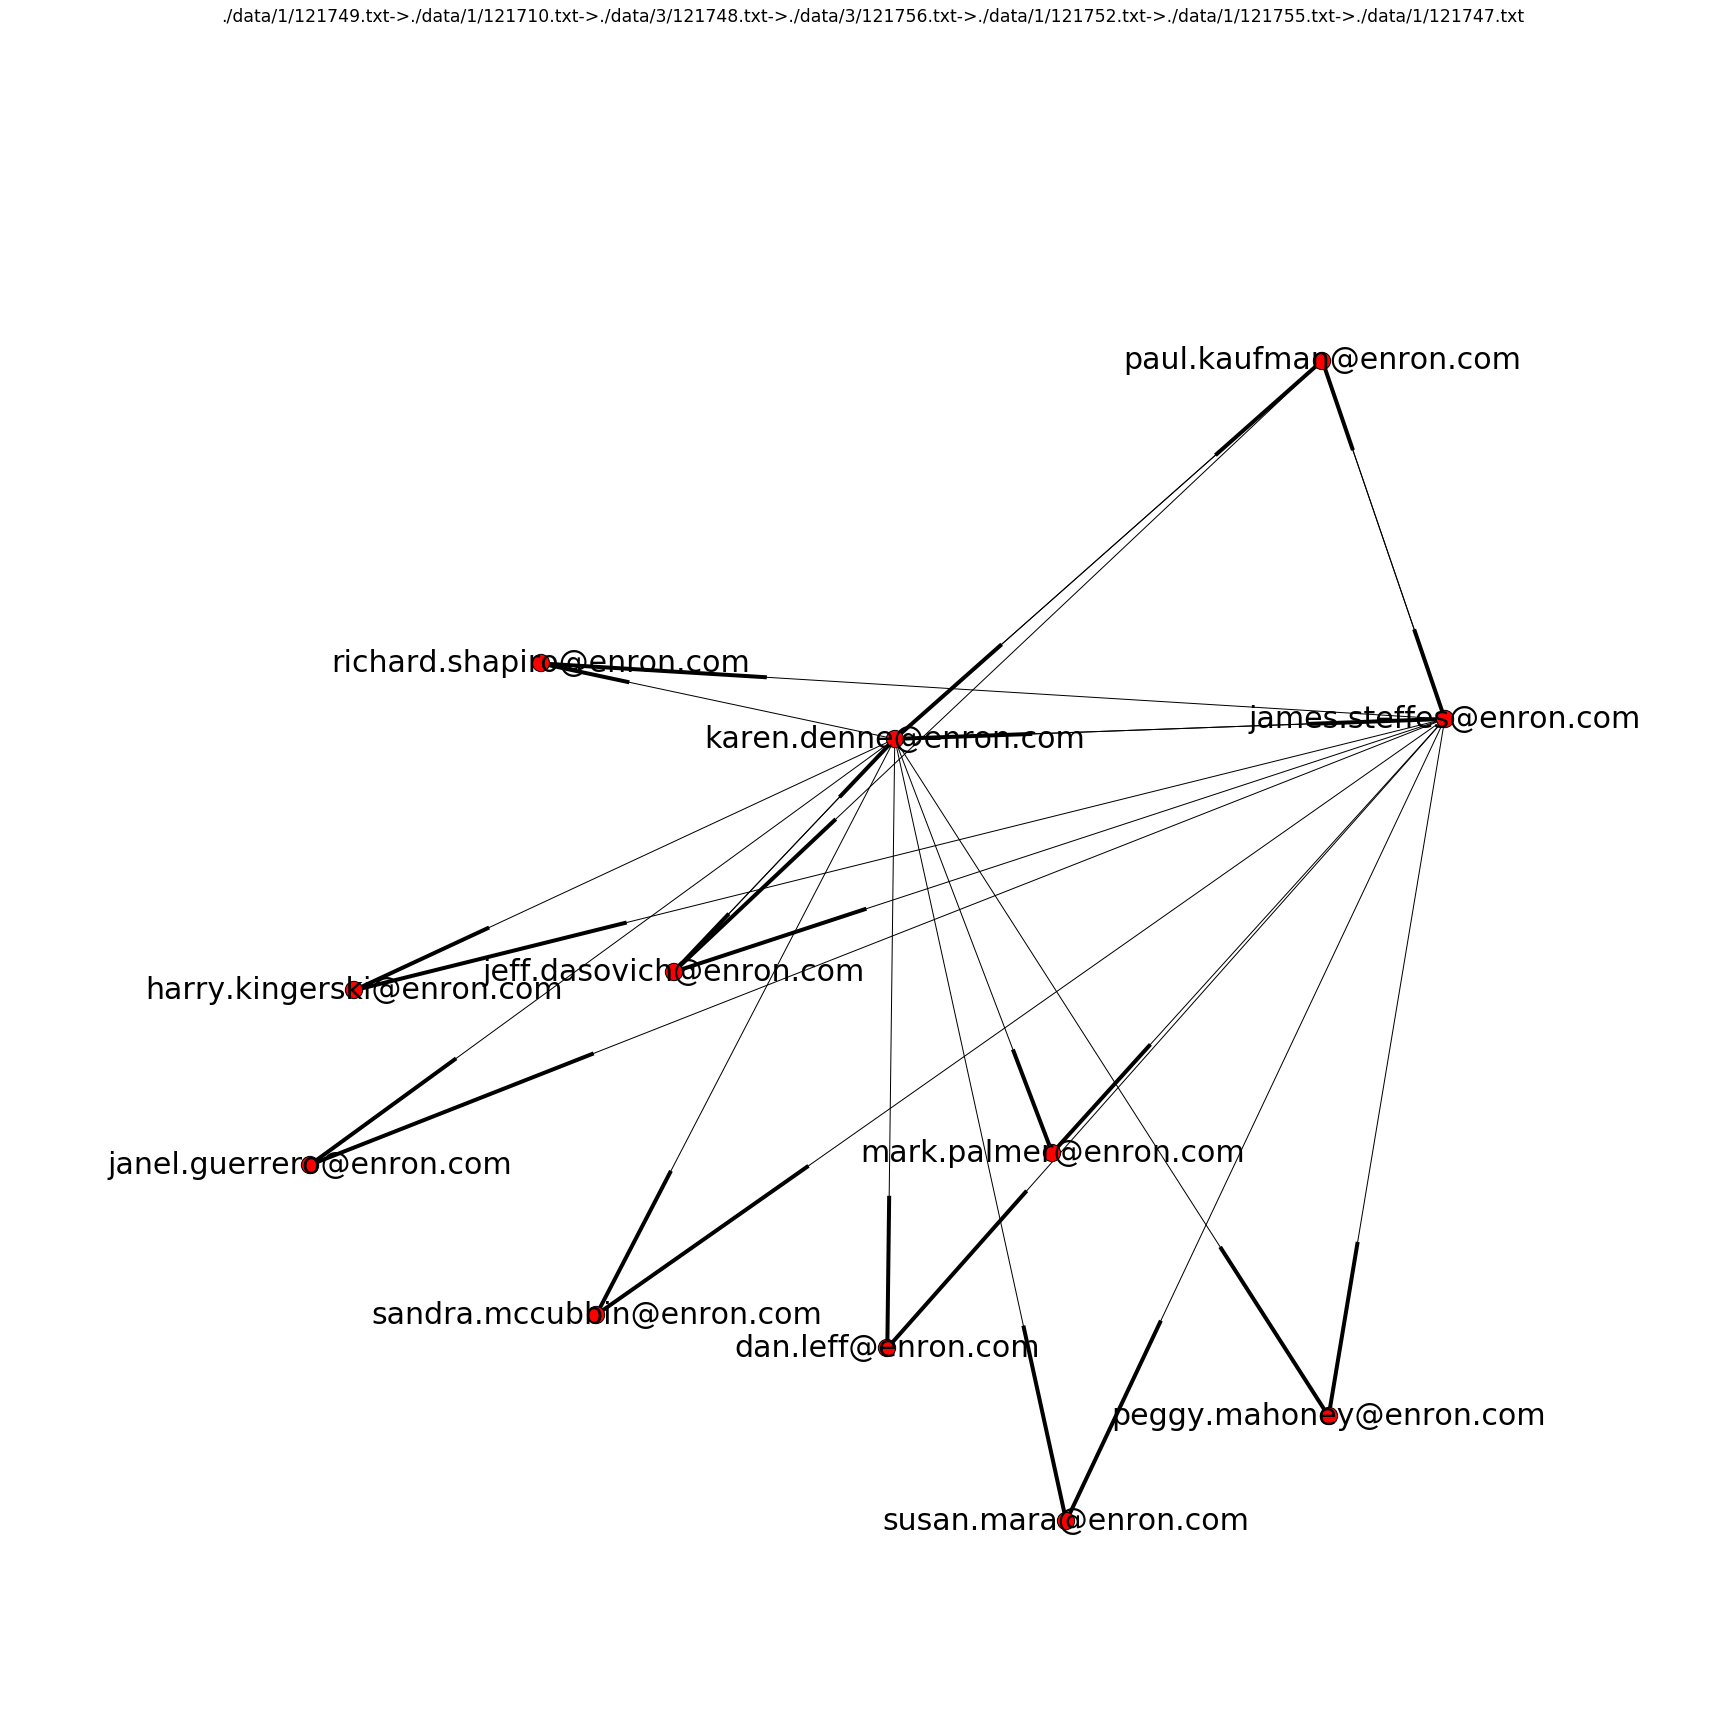

In [9]:
def get_sender_and_recipients(email_id, drop_domain):
    if not isinstance(email_id, basestring):
        return None, []
    sender = enronData.emails.loc[[email_id]].sender[0]
    if drop_domain:
        sender = sender.split("@",1)[0]
    recipients = [recipient.split("@",1)[0] if drop_domain else recipient 
                  for recipient in enronData.recipients[enronData.recipients.email_id.str.contains(email_id)].recipient]
    return sender, recipients

def graph_for_email_group(email_ids, drop_domain=False):
    reply_chain = nx.DiGraph()
    for email_id in email_ids:
        sender, recipients = get_sender_and_recipients(email_id, drop_domain)
        if not sender:
            continue
        for recipient in recipients:
            reply_chain.add_edge(sender, recipient)
            if 'weight' not in reply_chain[sender][recipient]:
                reply_chain[sender][recipient]['weight'] = 0
            reply_chain[sender][recipient]['weight'] += 1
    reply_chain.graph['dpi'] = 120
    return reply_chain

reply_chain_graph = graph_for_email_group(longest_reply_club)
fig, ax = plt.subplots(figsize=(30,30))
nx.draw(reply_chain_graph, ax=ax, with_labels=True, font_size=30)
ax.set_title('->'.join(longest_reply_club), size='xx-large')

-----------------
# Betweenness centrality

## Which people in the wider company graph have a higher betweenness centrality?

Name: 
Type: DiGraph
Number of nodes: 1365
Number of edges: 2440
Average in degree:   1.7875
Average out degree:   1.7875


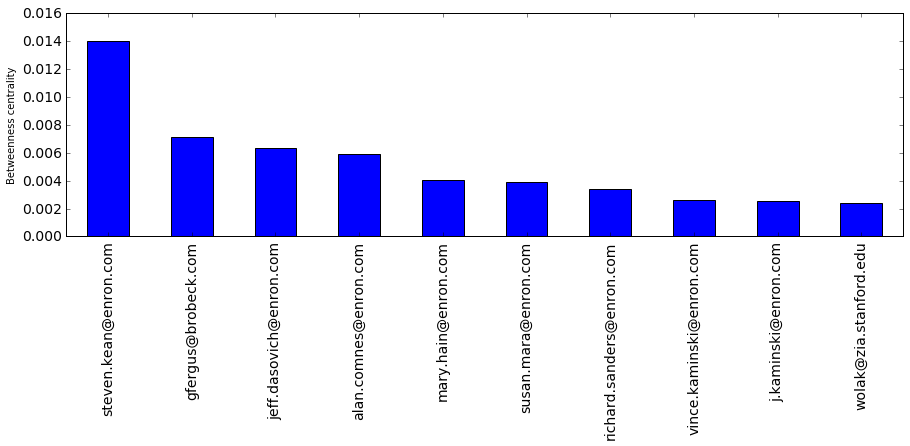

In [10]:
# Construct graph for all emails
super_graph = graph_for_email_group(enronData.email_files, drop_domain=False)
print nx.info(super_graph)
betweenness = nx.betweenness_centrality(super_graph)
betweenness = sorted(betweenness.items(), key=lambda x:x[1], reverse=True)
plot = (pd.DataFrame.from_dict({key:value for key, value in betweenness[:10]}, orient='index')
        .sort_values(0, ascending=[0])
        .plot(kind='bar', legend=False, figsize=(15, 4), fontsize=14))
plot.set_ylabel('Betweenness centrality')

## How do the betweenness centrality values change if we only look at the direct emails and not broadcasted ones?

Name: 
Type: DiGraph
Number of nodes: 374
Number of edges: 373
Average in degree:   0.9973
Average out degree:   0.9973


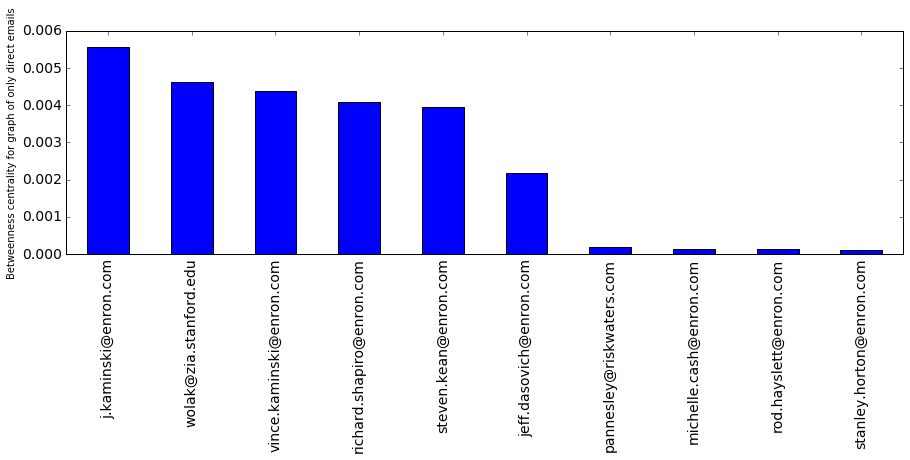

In [11]:
# Construct graph for all direct emails
email_ids_in_direct_emails = set([row[0] for _, row in enronData.emails[enronData.emails.num_recipients == 1][['email_id']].iterrows()])
direct_graph = graph_for_email_group(email_ids_in_direct_emails, drop_domain=False)
print nx.info(direct_graph)
betweenness_direct = nx.betweenness_centrality(direct_graph)
betweenness_direct = sorted(betweenness_direct.items(), key=lambda x:x[1], reverse=True)
plot = (pd.DataFrame.from_dict({key:value for key, value in betweenness_direct[:10]}, orient='index')
        .sort_values(0, ascending=[0])
        .plot(kind='bar', legend=False, figsize=(15, 4), fontsize=14))
plot.set_ylabel('Betweenness centrality for graph of only direct emails')

-------------------------
# Final Thoughts

This has been a fun exercise for me. I appreciate the time that you have extended to me to be able to sink my teeth into the problem to some extent. There is never a complete end to any exploration but only times when you decide/choose to let go. This is that time for me. 

## Other ideas to pursue

Some other unpursued thoughts in my head were the following:

1. I didn't really go into the details of the email contents much at all. Perhaps I could have used TF-IDF computations with 1-, 2- and 3-grams to find the words/phrases with high information content in various emails. This would have allowed me to explore and investiagate and drill down into the email content more easily.
2. Along the lines of the above, perhaps I could have done simple positive negative sentiment analysis to see if I could have pinpointed the time of the lowest morale in the company to see if it would have coincided with the imminent bankruptcy
3. A lot more data cleaning to help sift out valuable signal from exisiting features. Why should there be emails with no recipients? How to account of the large number of emails which just seemed to have forwarded articles pasted inline? Etcetera